# Load modules and define function(s)

In [1]:
## Load modules

import sys
sys.path.append('../code/')
import source
import importlib
importlib.reload(source)
from source.catalog import CatalogASCII
from source.skymap import PlanckMap
from source import map_params
import healpy as hp
import numpy as np
import astropy.units as au

import matplotlib
import matplotlib
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

## Plot clusters on healpix map
def plot_clusters(ra, dec):
    """
    Plots clusters overlaid on top of cmb map
    """
    hp.graticule()
    hp.projscatter(ra.to_value(au.deg), dec.to_value(au.deg), lonlat=True, c='r', marker='o', alpha=0.25)

# Load clusters and an example cmb map, sky masks

In [2]:
## Load clusters

catFile='../data/cluster/maxBCG_ID.dat'
`
## Load masks (here the cmb map only acts as a mask holder)
cmb_name = '../data/cmb/observed_map/HFI_SkyMap_143_2048_R3.01_full.fits'
common_mask_name = '../data/cmb/survey_mask/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits' # Planck2018 common mask
cmb_map = PlanckMap(mapFile=cmb_name,maskFile=common_mask_name)
ymap_mask_name = '../data/cmb/survey_mask/COM_CompMap_Compton-SZMap-PSmask_2048_R2.01.fits' # Planck y-map PS mask
cmb_map.combine_mask(ymap_mask_name)
SDSSgal_mask_name = '../data/borg_sdss/SDSS_DR12_mask_galactic.fits' # SDSS galactic mask
cmb_map.combine_mask(SDSSgal_mask_name)
cmb_map.rotate(coord=['G','C'],alms=False)

Total number of clusters originally (before any selection cut):
13823
Map unit changed from K to muK


True

# Apply redshift and sky selection cuts

In [3]:
# reshift cuts

## spectroscopic redshift cut

specz_cut = np.where(z>0.)
specz_cut = np.delete(specz_cut[0],np.where(specz_cut[0]==679)) # remove one cluster with false spectroscopic redshift

ID = ID[specz_cut]
z = z[specz_cut]
ra = ra[specz_cut]
dec = dec[specz_cut]
N200 = N200[specz_cut]

## reshift range cut

lowz_cut = np.where(z>0.21)

ID = ID[lowz_cut]
z = z[lowz_cut]
ra = ra[lowz_cut]
dec = dec[lowz_cut]
N200 = N200[lowz_cut]

N_cluster = ra.shape[0]
print("Total number of clusters after redshift cuts:")
print(N_cluster)

# Sky cut

## Planck+SDSS mask cuts
uncut_pix = hp.ang2pix(cmb_map.nside,ra.to_value(au.deg),dec.to_value(au.deg),lonlat=True)
skycut = np.where(cmb_map.map.mask[uncut_pix]==False)

ID = ID[skycut]
z = z[skycut]
ra = ra[skycut]
dec = dec[skycut]
N200 = N200[skycut]

N_cluster = ra.shape[0]
print("Total number of clusters after redshift and sky cuts:")
print(N_cluster)

Total number of clusters after redshift cuts:
2624
Total number of clusters after redshift and sky cuts:
2189


# Plot CMB map overlaid with selected clusters

0.0 180.0 -180.0 180.0


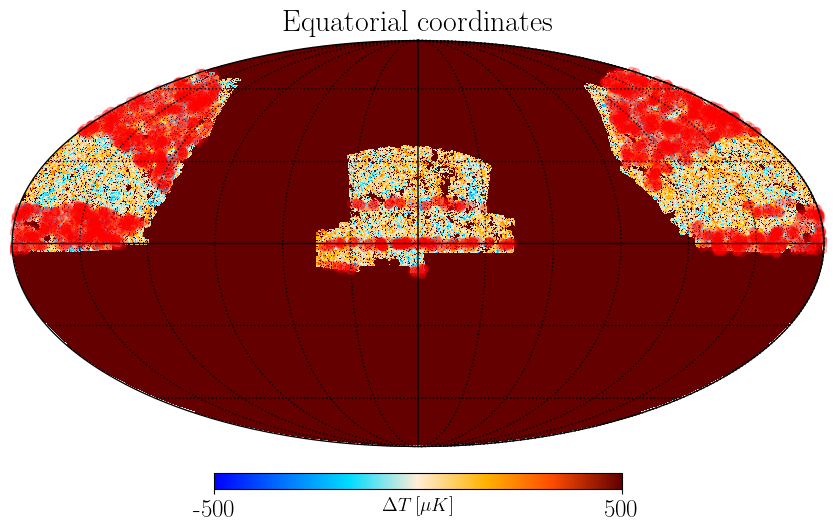

In [4]:
hp.mollview(cmb_map.map,min=-500.,max=500.,cmap=cmb_map.cmap,title='Equatorial coordinates',unit=r'$\Delta T\,[\mu K]$')
plot_clusters(ra,dec)
plt.show()

# Save the output

In [7]:
#selected_cluster_outfile = '../../CLUSTER_cat/maxBCG/maxBCG_ID_redshift_sky_selected.dat'
selected_cluster_outfile = '../data/cluster/maxBCG_ID_redshift_sky_selected.dat'

fmt = '%5d\t', '%3.7f\t', '%2.5f\t', '%-1.7f\t', '%-3d\n'
np.savetxt(selected_cluster_outfile,np.transpose((ID, ra,dec,z,N200)),fmt=fmt)
with open(selected_cluster_outfile, "a+") as f:
    f.write("#ID\t#ra\t#dec\t#spec-z\t#N200") # to the end of the file